In [1]:
from Functions.classes import LocalBinaryPatterns
from Functions.sklearn_plots import *
#from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd

from sklearn import metrics
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit,ShuffleSplit,cross_val_predict,cross_val_score,train_test_split, KFold
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
from skimage import data, img_as_ubyte
from skimage.io import imread, imshow
from skimage.color import rgb2hed, hed2rgb, rgb2gray

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#### Useful link for pipelines : https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976

## Classification avec features morphology/textural

In [12]:
os.chdir('/home/tien/Documents/tests/ISUP_test/data_label/morpho_texture_features/')

features_33 = np.loadtxt('data_33.txt')
features_34 = np.loadtxt('data_34.txt')
features_43 = np.loadtxt('data_43.txt')
features_44 = np.loadtxt('data_44.txt')
features_910 = np.loadtxt('data_910.txt')
label_33 = np.loadtxt('label_33.txt')
label_34 = np.loadtxt('label_34.txt')
label_43 = np.loadtxt('label_43.txt')
label_44 = np.loadtxt('label_44.txt')
label_910 = np.loadtxt('label_910.txt')

features = np.concatenate((features_33, features_34, features_43, features_44, features_910)) # shape 164 x 9
labels = np.concatenate((np.array([1]*(len(label_33) + len(label_34) + len(label_43))), np.array([2]*(len(label_44) + len(label_910))))) # shape (164,) # CLASSER GS < 7 VS GS > 7

In [37]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

scaler = preprocessing.StandardScaler().fit(X_train) # contient moyenne et variance du training set
X_train_transformed = scaler.transform(X_train)
clf = svm.SVC(C=1).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test) # Returns the mean accuracy on the given test data and labels.

0.8484848484848485

The preprocessing module further provides a utility class StandardScaler that implements the Transformer API to compute the mean and standard deviation on a training set so as to be able to later reapply the same transformation on the testing set.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)

# Gridsearch

clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(class_weight = {1:3}))
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-5, 2, 13)
param_grid = dict(svc__gamma=gamma_range, svc__C=C_range) 
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.20, random_state=42)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
#The best parameters are {'svc__C': 1000.0, 'svc__gamma': 0.00825404185268019} with a score of 0.83 avec class_weight = {1:4}
#The best parameters are {'svc__C': 10.0, 'svc__gamma': 0.4641588833612782} with a score of 0.83 avec class_weight = {1:3}

The best parameters are {'svc__C': 10.0, 'svc__gamma': 0.4641588833612782} with a score of 0.83


Training accuracy: 0.81 (+/- 0.23)
Testing accuracy: 0.83


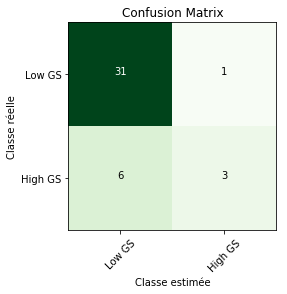

In [53]:
# Training
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=10.0, gamma=0.4641588833612782, class_weight = {1:3}))
training_score = cross_val_score(clf, X_train, y_train, cv=10)
print("Training accuracy: %0.2f (+/- %0.2f)" % (training_score.mean(), training_score.std() * 2))

# Testing
clf.fit(X_train, y_train)
testing_score = clf.score(X_test, y_test)
predictions = clf.predict(X_test) # Pour produire confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=['Low GS', 'High GS'], normalize=False, title='Confusion Matrix')
print("Testing accuracy: %0.2f" %testing_score)

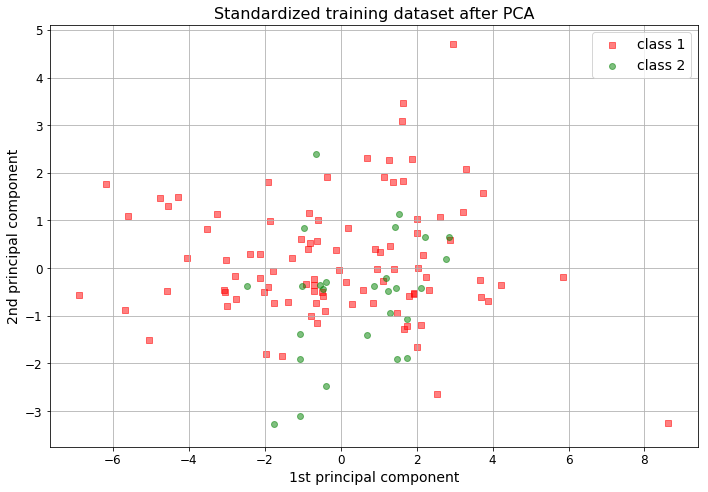

In [66]:
# Fit to data and predict using pipelined scaling, GNB and PCA.
std_clf = make_pipeline(preprocessing.StandardScaler(), PCA(n_components=2), GaussianNB())
std_clf.fit(X_train, y_train)

# Extract PCA from pipeline
pca_std = std_clf.named_steps['pca']
scaler = std_clf.named_steps['standardscaler']
X_train_std_transformed = pca_std.transform(scaler.transform(X_train))

# visualize standardized dataset with PCA performed
fig, ax = plt.subplots(ncols=1, figsize=(10,7))

for l, c, m in zip(range(1, 3), ('red', 'green'), ('s', 'o')):
    ax.scatter(X_train_std_transformed[y_train == l, 0],
                X_train_std_transformed[y_train == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )


ax.set_title('Standardized training dataset after PCA', fontsize=BIGGER_SIZE)


ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
ax.legend(loc='upper right')
ax.grid()

plt.tight_layout()

plt.show()

## Classification avec neighborhood features (stroma, lumen, nuclei neighbors/distance)

SVM for multiclass classification : https://www.kaggle.com/pranathichunduru/svm-for-multiclass-classification/code

In [3]:
os.chdir('/home/ehsan/Documents/Tien/histopathology/ISUP_test/results/2019-08-26/')
neigh_feat = np.loadtxt('neigh_feat.txt') # (163, 26)
dens_feat = np.loadtxt('dens_feat.txt') # (163, 16)
dens_wholeimg_feat = np.reshape(np.loadtxt('dens_wholeimg_feat.txt'), (163,1))
labels = np.loadtxt('labels.txt') # (163,)

combined_feat = np.hstack((neigh_feat, dens_feat, dens_wholeimg_feat)) # (163, 43)

# Cette cellule sert à produire le dataframe avec les labels, les grades, le nom des fichiers et les features vectors.
#Le dataframe est utilisé afin de pouvoir repérer les images mal classifiées à partir de leur index dans le dataframe.

path = '/home/ehsan/Documents/Tien/histopathology/ISUP_test/ISUP_images/'
grade_folders = sorted([f for f in os.listdir(path) if not f.startswith('.')]) # le if : ne pas prendre hidden files
# grade_folders : ['GS_33', 'GS_34', 'GS_43', 'GS_44', 'GS_910']

# 163 images cancer ISUP
images_33 = [image for image in os.listdir(path+grade_folders[0]) if '20X' in image] #57
images_34 = [image for image in os.listdir(path+grade_folders[1]) if '20X' in image] #62
images_43 = [image for image in os.listdir(path+grade_folders[2]) if '20X' in image] #9
images_44 = [image for image in os.listdir(path+grade_folders[3]) if '20X' in image] #16
images_910 = [image for image in os.listdir(path+grade_folders[4]) if '20X' in image] #19

images = images_33 + images_34 + images_43 + images_44 + images_910

grade_33 = ['GS_33' for i in range(len(images_33))]
grade_34 = ['GS_34' for i in range(len(images_34))]
grade_43 = ['GS_43' for i in range(len(images_43))]
grade_44 = ['GS_44' for i in range(len(images_44))]
grade_910 = ['GS_910' for i in range(len(images_910))]

grades = grade_33 + grade_34 + grade_43 + grade_44 + grade_910

df = pd.DataFrame(data=np.array([labels, grades, images, list(neigh_feat), list(dens_feat), list(dens_wholeimg_feat), list(combined_feat)]).transpose(),
                   columns=['labels', 'grades', 'images', 'neighborhood_features', 'density_patches_features', 'density_wholeimg_features', 'combined_features'])
df.to_pickle('dataframe_ISUP_20X.pkl')

In [7]:
df

labels  grades         images  \
0        1   GS_33  480_20X_3.jpg   
1        1   GS_33   1126_20X.jpg   
2        1   GS_33  628_20X_2.jpg   
3        1   GS_33    480_20X.jpg   
4        1   GS_33   1014_20X.jpg   
5        1   GS_33  480_20X_2.jpg   
6        1   GS_33    628_20X.jpg   
7        1   GS_33   1078_20X.jpg   
8        1   GS_33   1022_20X.jpg   
9        1   GS_33    990_20X.jpg   
10       1   GS_33    343_20X.jpg   
11       1   GS_33  343_20X_2.jpg   
12       1   GS_33   1026_20X.jpg   
13       1   GS_33   1062_20X.jpg   
14       1   GS_33   1098_20X.jpg   
15       1   GS_33   1074_20X.jpg   
16       1   GS_33    118_20X.jpg   
17       1   GS_33    207_20X.jpg   
18       1   GS_33   1346_20X.jpg   
19       1   GS_33    600_20X.jpg   
20       1   GS_33   1358_20X.jpg   
21       1   GS_33  480_20X_4.jpg   
22       1   GS_33   1002_20X.jpg   
23       1   GS_33   1354_20X.jpg   
24       1   GS_33   1146_20X.jpg   
25       1   GS_33  207_20X_3.jpg   
26       1   GS_33   1362_20X.jpg   
27       1   GS_33    826_20X.jpg   
28       1   GS_33    554_20X.jpg   
29       1   GS_33   1310_20X.jpg   
..     ...     ...            ...   
133      4   GS_44    275_20X.jpg   
134      4   GS_44  613_20X_3.jpg   
135      4   GS_44   1334_20X.jpg   
136      4   GS_44    227_20X.jpg   
137      4   GS_44  306_20X_2.jpg   
138      4   GS_44  613_20X_2.jpg   
139      4   GS_44  832_20X_3.jpg   
140      4   GS_44    306_20X.jpg   
141      4   GS_44   1298_20X.jpg   
142      4   GS_44  306_20X_4.jpg   
143      4   GS_44   1050_20X.jpg   
144      5  GS_910    664_20X.jpg   
145      5  GS_910  141_20X_2.jpg   
146      5  GS_910  635_20X_2.jpg   
147      5  GS_910    635_20X.jpg   
148      5  GS_910  793_20X_3.jpg   
149      5  GS_910  242_20X_2.jpg   
150      5  GS_910    141_20X.jpg   
151      5  GS_910  793_20X_4.jpg   
152      5  GS_910  744_20X_2.jpg   
153      5  GS_910  664_20X_2.jpg   
154      5  GS_910  635_20X_3.jpg   
155      5  GS_910    793_20X.jpg   
156      5  GS_910    242_20X.jpg   
157      5  GS_910  793_20X_2.jpg   
158      5  GS_910  744_20X_3.jpg   
159      5  GS_910  664_20X_3.jpg   
160      5  GS_910  635_20X_4.jpg   
161      5  GS_910    744_20X.jpg   
162      5  GS_910  242_20X_3.jpg   

                                 neighborhood_features  \
0    [355.158320687911, 700.1881638846737, 1129.394...   
1    [274.4800724637681, 526.088768115942, 841.9746...   
2    [362.7687544653489, 707.413193617528, 1139.738...   
3    [348.4574285714286, 699.4482857142857, 1137.57...   
4    [202.60481503229596, 404.1021726365238, 664.20...   
5    [362.509645464025, 717.9655891553701, 1162.271...   
6    [334.09794296400185, 649.7302477793361, 1041.4...   
7    [309.24820430965684, 574.4126097366321, 903.88...   
8    [346.6017222820237, 672.2152852529601, 1074.08...   
9    [255.81122702434178, 506.4629905613512, 824.47...   
10   [340.59822389666306, 671.6969860064586, 1088.3...   
11   [280.5499016715831, 549.8419370698132, 888.514...   
12   [385.04447949526815, 707.2173501577287, 1112.0...   
13   [300.1395973154362, 582.8062639821029, 943.133...   
14   [350.0638497652582, 667.6507042253521, 1060.86...   
15   [311.6380231522707, 605.7818343722173, 975.448...   
16   [341.1676099259904, 660.3720069656073, 1055.71...   
17   [356.16689798750866, 719.5374739764053, 1178.0...   
18   [275.78092399403874, 539.220566318927, 869.170...   
19   [294.08375763747455, 574.0613543788187, 923.84...   
20   [224.0468681559352, 447.7332457293036, 736.619...   
21   [292.97726136931533, 581.2633683158421, 941.63...   
22   [344.69608284556506, 644.1202161188654, 1013.6...   
23   [325.88387824126266, 619.2175873731679, 985.38...   
24   [330.264361972547, 628.6110828673106, 998.5124...   
25   [360.46236872812136, 711.9976662777129, 1149.3...   
26   [222.36506378802747, 444.01472031403335, 727.9...   
27   [403.22709348179075, 770.4634655532359, 1231.4...   
28   [369.38711367207964, 7

In [2]:
os.chdir('/home/ehsan/Documents/Tien/histopathology/ISUP_test/results/2019-07-08/')
df = pd.read_pickle('dataframe_ISUP_20X.pkl')
#df

In [4]:
X, y = df.neighborhood_features, df.labels
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.20, stratify=y)

# Pour pas avoir un array de taille (# samples, ). Cette étape permet d'avoir un array de taille (# samples x # features)
X_train = np.array([X_train_df.values[i] for i in range(len(X_train_df.values))])
X_test = np.array([X_test_df.values[i] for i in range(len(X_test_df.values))])

# Les labels df.labels sont dtype('0') (object). On converti en entiers.
y_train = y_train_df.values.astype(int)
y_test = y_test_df.values.astype(int)

In [5]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('SVM', SVC(class_weight='balanced'))]) 

params_grid = [{'SVM__kernel': ['rbf'], 'SVM__gamma': [0.001, 0.01, 0.1, 1], 'SVM__C': [0.001, 0.01, 0.1, 1, 10]},
               {'SVM__kernel': ['linear'], 'SVM__C': [0.001, 0.01, 0.1, 1, 10]}]

svm_model = GridSearchCV(pipeline, param_grid=params_grid, cv=10)
svm_model.fit(X_train, y_train)

# View the accuracy score
print('Best mean cross-validated score for training data:', svm_model.best_score_,"\n")

# View the best parameters for the model found using grid search
print('Best params : ', svm_model.best_params_)

/home/ehsan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Best mean cross-validated score for training data: 0.43846153846153846 

Best params :  {'SVM__C': 1, 'SVM__kernel': 'linear'}


/home/ehsan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Testing set score for SVM: 0.424242


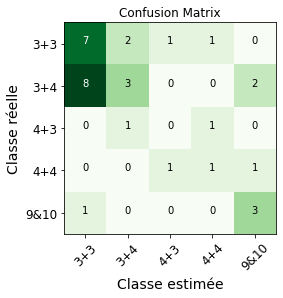

In [6]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)

cnf_matrix = confusion_matrix(y_test, Y_pred)
plot_confusion_matrix(cnf_matrix, classes=['3+3', '3+4', '4+3', '4+4', '9&10'], normalize=False, title='Confusion Matrix')

print("Testing set score for SVM: %f" % final_model.score(X_test, y_test))

### Classification avec polygon areas seulement

In [21]:
polyfeat_all = np.loadtxt('polyfeat_all.txt') # (163, 2)

X, y = polyfeat_all, labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) #essayer test_size=0.30

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fits transformer to X_train and returns a transformed version of X
X_test_scaled = scaler.transform(X_test) # Perform standardization by centering and scaling

params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}, 
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train_scaled, y_train)

# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

Best score for training data: 0.4473684210526316 

Best C: 1000 

Best Kernel: rbf 

Best Gamma: 0.001 



/home/tien/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Training set score for SVM: 0.447368
Testing  set score for SVM: 0.224490


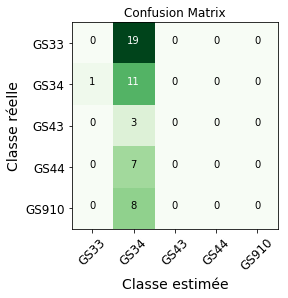

In [22]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test_scaled)

cnf_matrix = confusion_matrix(y_test, Y_pred)
plot_confusion_matrix(cnf_matrix, classes=['GS33', 'GS34', 'GS43', 'GS44', 'GS910'], normalize=False, title='Confusion Matrix')

print("Training set score for SVM: %f" % final_model.score(X_train_scaled , y_train))
print("Testing  set score for SVM: %f" % final_model.score(X_test_scaled  , y_test ))

## Classification with density features (patches)

In [8]:
X, y = df.density_patches_features, df.labels
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.20, stratify=y)

# Pour pas avoir un array de taille (# samples, ). Cette étape permet d'avoir un array de taille (# samples x # features)
X_train = np.array([X_train_df.values[i] for i in range(len(X_train_df.values))])
X_test = np.array([X_test_df.values[i] for i in range(len(X_test_df.values))])

# Les labels df.labels sont dtype('0') (object). On converti en entiers.
y_train = y_train_df.values.astype(int)
y_test = y_test_df.values.astype(int)

In [9]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('SVM', SVC(class_weight='balanced'))]) 

params_grid = [{'SVM__kernel': ['rbf'], 'SVM__gamma': [0.001, 0.01, 0.1, 1], 'SVM__C': [0.001, 0.01, 0.1, 1, 10]},
               {'SVM__kernel': ['linear'], 'SVM__C': [0.001, 0.01, 0.1, 1, 10]}]

svm_model = GridSearchCV(pipeline, param_grid=params_grid, cv=10)
svm_model.fit(X_train, y_train)

# View the accuracy score
print('Best mean cross-validated score for training data:', svm_model.best_score_,"\n")

# View the best parameters for the model found using grid search
print('Best params : ', svm_model.best_params_)

/home/ehsan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Best mean cross-validated score for training data: 0.47692307692307695 

Best params :  {'SVM__C': 10, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}


/home/ehsan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Testing set score for SVM: 0.484848


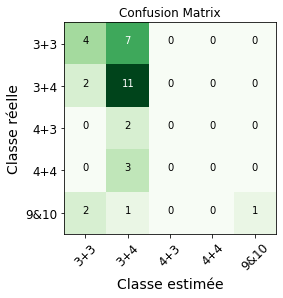

In [10]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)

cnf_matrix = confusion_matrix(y_test, Y_pred)
plot_confusion_matrix(cnf_matrix, classes=['3+3', '3+4', '4+3', '4+4', '9&10'], normalize=False, title='Confusion Matrix')

print("Testing set score for SVM: %f" % final_model.score(X_test, y_test))

## Classification with density whole image features

/home/ehsan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Best mean cross-validated score for training data: 0.36923076923076925 

Best params :  {'SVM__C': 0.1, 'SVM__kernel': 'linear'}
Testing set score for SVM: 0.181818


/home/ehsan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


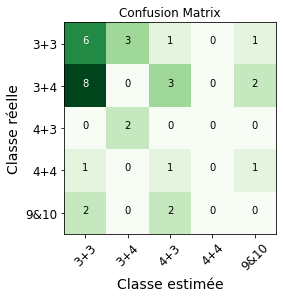

In [11]:
X, y = df.density_wholeimg_features, df.labels
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.20, stratify=y)

# Pour pas avoir un array de taille (# samples, ). Cette étape permet d'avoir un array de taille (# samples x # features)
X_train = np.array([X_train_df.values[i] for i in range(len(X_train_df.values))])
X_test = np.array([X_test_df.values[i] for i in range(len(X_test_df.values))])
# Les labels df.labels sont dtype('0') (object). On converti en entiers.
y_train = y_train_df.values.astype(int)
y_test = y_test_df.values.astype(int)

pipeline = Pipeline([('scaler', StandardScaler()),
                     ('SVM', SVC(class_weight='balanced'))]) 
params_grid = [{'SVM__kernel': ['rbf'], 'SVM__gamma': [0.001, 0.01, 0.1, 1], 'SVM__C': [0.001, 0.01, 0.1, 1, 10]},
               {'SVM__kernel': ['linear'], 'SVM__C': [0.001, 0.01, 0.1, 1, 10]}]

svm_model = GridSearchCV(pipeline, param_grid=params_grid, cv=10)
svm_model.fit(X_train, y_train)

# View the accuracy score
print('Best mean cross-validated score for training data:', svm_model.best_score_,"\n")

# View the best parameters for the model found using grid search
print('Best params : ', svm_model.best_params_)


final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)

cnf_matrix = confusion_matrix(y_test, Y_pred)
plot_confusion_matrix(cnf_matrix, classes=['3+3', '3+4', '4+3', '4+4', '9&10'], normalize=False, title='Confusion Matrix')

print("Testing set score for SVM: %f" % final_model.score(X_test, y_test))

## Combination neighborhood features and nuclei density patches features

In [12]:
X, y = df.combined_features, df.labels
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y, test_size=0.20, stratify=y) # stratify parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.

# Pour pas avoir un array de taille (# samples, ). Cette étape permet d'avoir un array de taille (# samples x # features)
X_train = np.array([X_train_df.values[i] for i in range(len(X_train_df.values))])
X_test = np.array([X_test_df.values[i] for i in range(len(X_test_df.values))])

# Les labels df.labels sont dtype('0') (object). On converti en entiers.
y_train = y_train_df.values.astype(int)
y_test = y_test_df.values.astype(int)

In [13]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('SVM', SVC(class_weight='balanced'))]) 

params_grid = [{'SVM__kernel': ['rbf'], 'SVM__gamma': [0.001, 0.01, 0.1, 1], 'SVM__C': [0.001, 0.01, 0.1, 1, 10]},
               {'SVM__kernel': ['linear'], 'SVM__C': [0.001, 0.01, 0.1, 1, 10]}]

svm_model = GridSearchCV(pipeline, param_grid=params_grid, cv=10)
svm_model.fit(X_train, y_train)

# View the accuracy score
print('Best mean cross-validated score for training data:', svm_model.best_score_,"\n")

# View the best parameters for the model found using grid search
print('Best params : ', svm_model.best_params_)

/home/ehsan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Best mean cross-validated score for training data: 0.45384615384615384 

Best params :  {'SVM__C': 1, 'SVM__kernel': 'linear'}


/home/ehsan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Testing set score for SVM: 0.575758


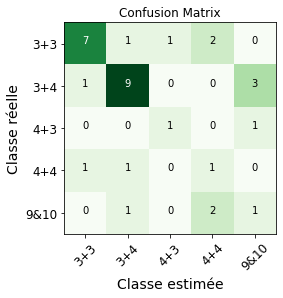

In [14]:
final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)

cnf_matrix = confusion_matrix(y_test, Y_pred)
plot_confusion_matrix(cnf_matrix, classes=['3+3', '3+4', '4+3', '4+4', '9&10'], normalize=False, title='Confusion Matrix')

print("Testing set score for SVM: %f" % final_model.score(X_test, y_test))

In [74]:
# Obtenir les indices de y_test permettant d'aller retrouver les images test mal classifiées
wrong_indices_test = []
wrong_labels_unsorted = []
count = 0
for row_index, (input, prediction, label) in enumerate(zip (X_test, Y_pred, y_test)):
    if prediction != label:
        print('Row', row_index, 'has been classified as ', prediction, 'and should be ', label)
        wrong_indices_test.append(row_index)
        wrong_labels_unsorted.append(prediction)
        count +=1

wrong_predictions_indices = np.sort(y_test_df.index.values[wrong_indices_test]) # les indices pour aller chercher les images test mal classifiées sur tout le dataframe
indices_sort_labels = np.argsort(y_test_df.index.values[wrong_indices_test]) # l'ordre des indices pour aller chercher les predicted labels dans le même ordre que "wrong_predictions_indices"
wrong_labels_sorted = np.array(wrong_labels_unsorted)[indices_sort_labels] # predicted labels triés dans l'ordre dans true labels
print("%i wrong predictions out of %i test samples" %(count, len(y_test)))

Row 0 has been classified as  2 and should be  4
Row 2 has been classified as  5 and should be  2
Row 3 has been classified as  2 and should be  1
Row 6 has been classified as  2 and should be  1
Row 14 has been classified as  1 and should be  4
Row 15 has been classified as  1 and should be  5
Row 16 has been classified as  4 and should be  2
Row 17 has been classified as  3 and should be  4
Row 19 has been classified as  3 and should be  2
Row 20 has been classified as  3 and should be  1
Row 21 has been classified as  1 and should be  2
Row 24 has been classified as  4 and should be  5
Row 25 has been classified as  2 and should be  5
Row 28 has been classified as  5 and should be  2
Row 29 has been classified as  1 and should be  2
15 wrong predictions out of 33 test samples


In [75]:
df_wrong_predictions = df.iloc[wrong_predictions_indices].drop(columns=['neighborhood_features', 'density_features', 'combined_features'])
df_wrong_predictions['predicted_labels'] = wrong_labels_sorted
display(df_wrong_predictions)

labels  grades         images  predicted_labels
2        1   GS_33  628_20X_2.jpg                 2
41       1   GS_33    549_20X.jpg                 3
45       1   GS_33   1350_20X.jpg                 2
70       2   GS_34    699_20X.jpg                 1
73       2   GS_34    760_20X.jpg                 5
78       2   GS_34  565_20X_2.jpg                 4
91       2   GS_34   1010_20X.jpg                 5
98       2   GS_34  281_20X_3.jpg                 3
115      2   GS_34  559_20X_3.jpg                 1
128      4   GS_44   1322_20X.jpg                 1
129      4   GS_44    613_20X.jpg                 3
141      4   GS_44   1298_20X.jpg                 2
144      5  GS_910    664_20X.jpg                 4
157      5  GS_910  793_20X_2.jpg                 2
159      5  GS_910  664_20X_3.jpg                 1

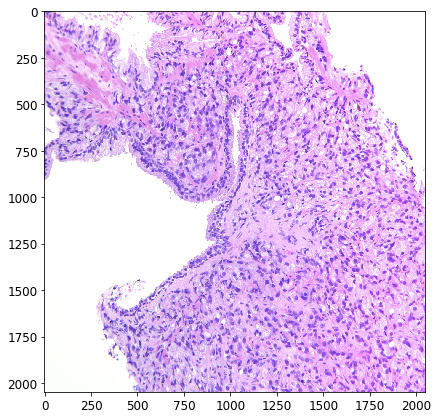

In [33]:
# Visualiser les images mal classifiées
plt.figure(figsize=(7,7))
plt.imshow(imread('/home/tien/Documents/tests/ISUP_test/ISUP_images/GS_910/664_20X.jpg'))
plt.show()

## Feature selection on combined features

In [15]:
feature_descriptor = np.array(['stroma_per_nucleus_patch1', 'stroma_per_nucleus_patch2', 'stroma_per_nucleus_patch3', 'stroma_per_nucleus_mean', 'stroma_per_nucleus_var',
                               'lumen_per_nucleus_patch1', 'lumen_per_nucleus_patch2', 'lumen_per_nucleus_patch3', 'lumen_per_nucleus_mean', 'lumen_per_nucleus_var',
                               'max_distances_patch1', 'max_distances_patch2', 'max_distances_patch3', 'max_distances_mean', 'max_distances_var',
                               'min_distances_patch1', 'min_distances_patch2', 'min_distances_patch3', 'min_distances_mean', 'min_distances_var',
                               'neighbors_patch1', 'neighbors_patch2', 'neighbors_patch3', 'neighbors_mean', 'neighbors_var', 'nuclei_morphology',
                               'np.amin(num_nuclei_densities)', 'np.amax(num_nuclei_densities)', 'np.mean(num_nuclei_densities)', 'np.var(num_nuclei_densities)',
                               'np.amin(nuclei_densities)', 'np.amax(nuclei_densities)', 'np.mean(nuclei_densities)', 'np.var(nuclei_densities)', 
                               'np.amin(lumen_densities)','np.amax(lumen_densities)', 'np.mean(lumen_densities)', 'np.var(lumen_densities)', 
                               'np.amin(eosin_densities)', 'np.amax(eosin_densities)', 'np.mean(eosin_densities)', 'np.var(eosin_densities)',
                               'density_wholeimg'])

### Feature importances with Extra Trees classifier

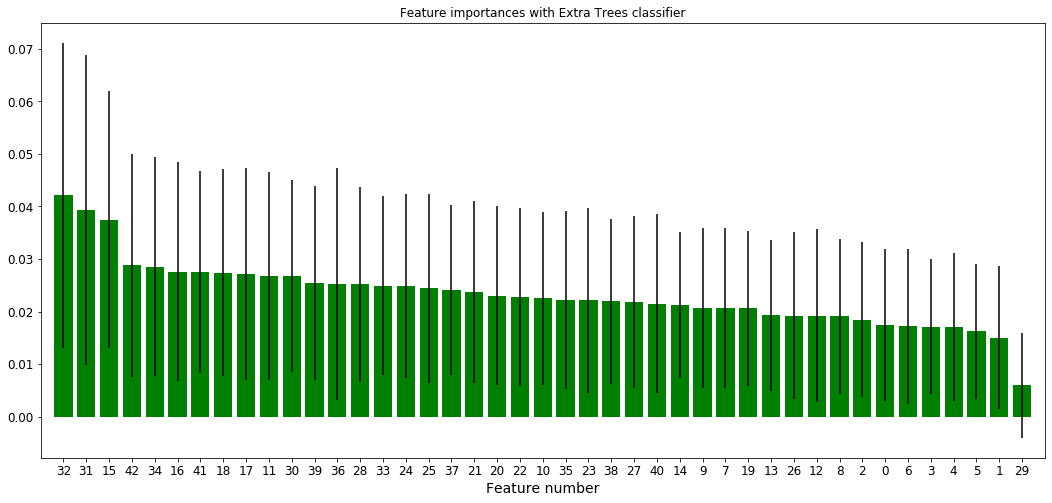

In [16]:
# ExtraTrees (extremely randomized trees) classifier always tests random splits over fraction of features (in contrast to RandomForest, which tests all possible splits over fraction of features)
#df = df[:144]
X = np.array([df.combined_features.values[i] for i in range(len(df.combined_features.values))])
y = df.labels.values.astype(int)

ET = ExtraTreesClassifier(n_estimators=250, random_state=0) 
ET.fit(X, y)
ET_importances = ET.feature_importances_
ET_std = np.std([tree.feature_importances_ for tree in ET.estimators_], axis=0)
ET_indices = np.argsort(ET_importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(18,8))
plt.title("Feature importances with Extra Trees classifier")
plt.bar(range(X.shape[1]), ET_importances[ET_indices],
       color="g", yerr=ET_std[ET_indices], align="center")
plt.xticks(range(X.shape[1]), ET_indices)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Feature number')
plt.show()

In [17]:
feature_descriptor[ET_indices]

array(['np.mean(nuclei_densities)', 'np.amax(nuclei_densities)',
       'min_distances_patch1', 'density_wholeimg',
       'np.amin(lumen_densities)', 'min_distances_patch2',
       'np.var(eosin_densities)', 'min_distances_mean',
       'min_distances_patch3', 'max_distances_patch2',
       'np.amin(nuclei_densities)', 'np.amax(eosin_densities)',
       'np.mean(lumen_densities)', 'np.mean(num_nuclei_densities)',
       'np.var(nuclei_densities)', 'neighbors_var', 'nuclei_morphology',
       'np.var(lumen_densities)', 'neighbors_patch2', 'neighbors_patch1',
       'neighbors_patch3', 'max_distances_patch1',
       'np.amax(lumen_densities)', 'neighbors_mean',
       'np.amin(eosin_densities)', 'np.amax(num_nuclei_densities)',
       'np.mean(eosin_densities)', 'max_distances_var',
       'lumen_per_nucleus_var', 'lumen_per_nucleus_patch3',
       'min_distances_var', 'max_distances_mean',
       'np.amin(num_nuclei_densities)', 'max_distances_patch3',
       'lumen_per_nucleus_mean', 

### Feature importance with Random Forest classifier

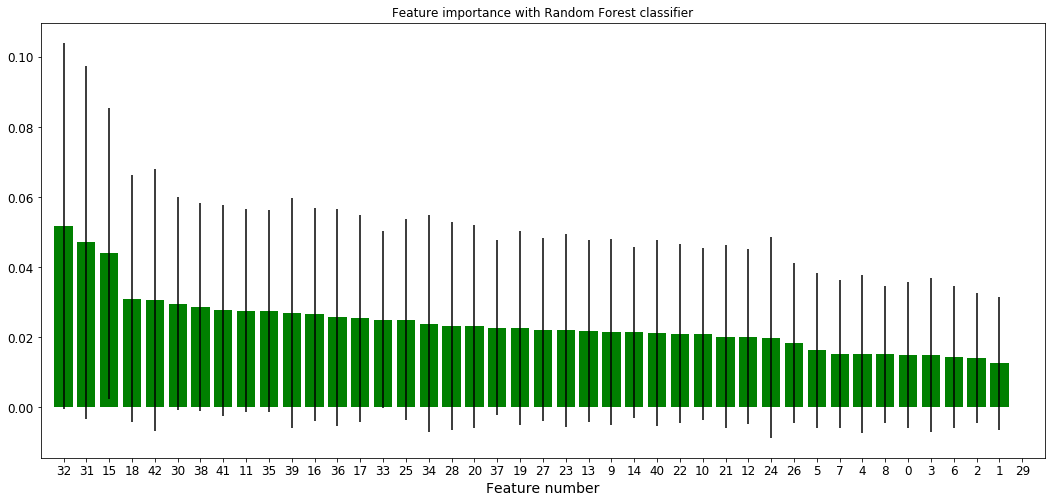

In [18]:
RF = RandomForestClassifier(n_estimators=250, random_state=0) 
RF.fit(X, y)
RF_importances = RF.feature_importances_
RF_std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)
RF_indices = np.argsort(RF_importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(18,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), RF_importances[RF_indices],
       color="g", yerr=RF_std[RF_indices], align="center")
plt.xticks(range(X.shape[1]), RF_indices)
plt.xlim([-1, X.shape[1]])
plt.title('Feature importance with Random Forest classifier')
plt.xlabel('Feature number')
plt.show()

In [19]:
feature_descriptor[RF_indices]

array(['np.mean(nuclei_densities)', 'np.amax(nuclei_densities)',
       'min_distances_patch1', 'min_distances_mean', 'density_wholeimg',
       'np.amin(nuclei_densities)', 'np.amin(eosin_densities)',
       'np.var(eosin_densities)', 'max_distances_patch2',
       'np.amax(lumen_densities)', 'np.amax(eosin_densities)',
       'min_distances_patch2', 'np.mean(lumen_densities)',
       'min_distances_patch3', 'np.var(nuclei_densities)',
       'nuclei_morphology', 'np.amin(lumen_densities)',
       'np.mean(num_nuclei_densities)', 'neighbors_patch1',
       'np.var(lumen_densities)', 'min_distances_var',
       'np.amax(num_nuclei_densities)', 'neighbors_mean',
       'max_distances_mean', 'lumen_per_nucleus_var', 'max_distances_var',
       'np.mean(eosin_densities)', 'neighbors_patch3',
       'max_distances_patch1', 'neighbors_patch2', 'max_distances_patch3',
       'neighbors_var', 'np.amin(num_nuclei_densities)',
       'lumen_per_nucleus_patch1', 'lumen_per_nucleus_patch3',
     

### Univariate feature selection

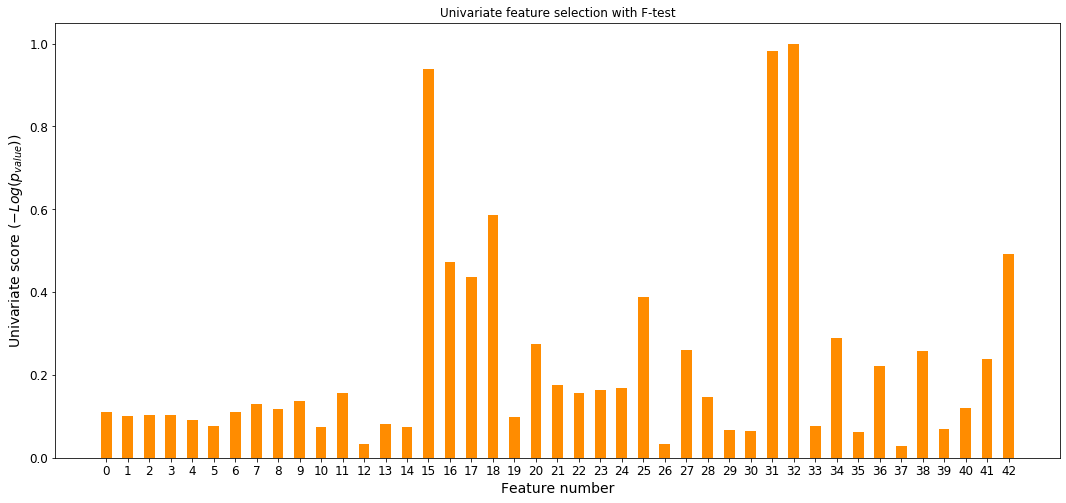

In [20]:
# Univariate feature selection with F-test for feature scoring
# We use the default selection function: the 10% most significant features
%matplotlib inline
plt.figure(figsize=(18,8))
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
X_indices = np.arange(X.shape[-1])
plt.bar(X_indices - .45, scores, width=.5, color='darkorange', tick_label=X_indices)
plt.title('Univariate feature selection with F-test')
plt.xlabel('Feature number')
plt.ylabel(r'Univariate score ($-Log(p_{value})$)')
plt.axis('tight')
plt.show()